<a href="https://colab.research.google.com/github/rmorlowski/Artificial-Intelligence-Deep-Learning/blob/master/pediatric_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Pediatric Pneumonia

This notebook works through a series of experiments aimed at creating a convolutional neural network (convnet) that can accurately distinguish between x-ray images of pediatric patients with and without pneumonia.

The dataset is a set of 5,856 x-ray images from patients 1-5 years old who received care at the Guangzhou Women and Children's Medical Center.  It was made available by Paul Mooney on kaggle.com:[ https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia]( https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


**Source:** [Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), "Labeled Optical Coherence Tomgraphy (OCT) and Chest X-Ray Images for Classfication", Mendeley Data, v2](https://dx.doi.org/10.17632/rscbjbr9sj.2)

Relevant documentation includes:
*   [J. Mattes - pediatric-pneumonia-detection](https://github.com/jomattes/pediatric-pneumonia-detection)
*   [N. Gift - Red Wine Quality_kaggle_data](https://colab.research.google.com/drive/1AIcdA-CYkr_ufQym1nl-WrK-Sls61eZ6)
*   [kaggle api](https://github.com/Kaggle/kaggle-api)
*   [Keras](https://keras.io/)
*  [B. Rocca - Handling Imbalanced Datasets in Machine Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)
*   [A. Bronshtein - Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)



Among the network topologies (structures) you test in this assignment, there should be at least one network with two hidden layers and a network that employs convolution operators (that is, a convolutional neural network). A useful exercise is to compare processing requirements and predictive accuracy of networks with two, three, or more hidden layers, with at least one (but perhaps more than one) of those layers involving a convolution operator.

---


Check for GPU

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Section 1: Ingest - Data Survey

Getting the data.

**Mount GDrive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


List in python

In [0]:
import os;os.listdir("/content/gdrive/My Drive/kaggle")

['kaggle.json']

List in bash

In [0]:
!ls -l /content/gdrive/My\ Drive/kaggle

total 1
-rw------- 1 root root 66 Jun 24 15:03 kaggle.json


#### Wire up Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json

Search kaggle datasets.

In [0]:
!kaggle datasets list -s chest

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia                       Chest X-Ray Images (Pneumonia)                        1GB  2018-03-24 19:41:59          14456  
nih-chest-xrays/data                                         NIH Chest X-rays                                     42GB  2018-02-21 20:52:23          20993  
nih-chest-xrays/sample                                       Random Sample of NIH Chest X-ray Dataset              2GB  2017-11-23 02:58:24           4679  
kmader/pulmonary-chest-xray-abnormalities                    Pulmonary Chest X-Ray Abnormalities                   4GB  2018-03-09 17:46:12           2327  
yashprakash13/chest-xrays-dataset                         

**Get kaggle dataset**

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!ls -l /content
!unzip /content/chest_xray.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
total 2415480
-rw-r--r-- 1 root root 1236184657 Jun 25 22:40 chest-xray-pneumonia.zip
-rw-r--r-- 1 root root 1237249419 Mar 24  2018 chest_xray.zip
drwx------ 3 root root       4096 Jun 25 22:40 gdrive
drwxr-xr-x 1 root root       4096 Jun 18 16:14 sample_data
Archive:  /content/chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/P

In [0]:
import os, fnmatch
from pathlib import Path

base_dir = "/content/chest_xray"
# base_dir = 'C:\\Users\\jonathanm\\Dropbox\\Northwestern\\MSDS 458\\Final Project\\chest-xray-pneumonia\\chest_xray\\chest_xray'

**Train / Validation / Testing Split**

Train/Test split and cross validation are two rather important concepts in data science and data analysis and are used as tools to prevent (or at least minimize) overfitting. I’ll explain what that is — when we’re using a statistical model (like linear regression, for example), we usually fit the model on a training set in order to make predications on a data that wasn’t trained (general data). Overfitting means that what we’ve fit the model too much to the training data.

![Train, Validatin, Test](https://cdn-images-1.medium.com/max/800/1*4G__SV580CxFj78o9yUXuQ.png)

![alt text](https://cdn-images-1.medium.com/max/800/1*tBErXYVvTw2jSUYK7thU2A.png)

Load data into training, validation, and test directories.

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Label directory names

In [0]:
# directory names
normal_train_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_train_dir = os.path.join(train_dir, 'PNEUMONIA')
normal_val_dir = os.path.join(val_dir, 'NORMAL')
pneumonia_val_dir = os.path.join(val_dir, 'PNEUMONIA')
normal_test_dir = os.path.join(test_dir, 'NORMAL')
pneumonia_test_dir = os.path.join(test_dir, 'PNEUMONIA')

Check the number of files in the directory

In [0]:
# number of .jpeg files in each image category
normal_train_len = len(fnmatch.filter(os.listdir(normal_train_dir), '*.jpeg'))
pneumonia_train_len = len(fnmatch.filter(os.listdir(pneumonia_train_dir), '*.jpeg'))
normal_val_len = len(fnmatch.filter(os.listdir(normal_val_dir), '*.jpeg'))
pneumonia_val_len = len(fnmatch.filter(os.listdir(pneumonia_val_dir), '*.jpeg'))
normal_test_len = len(fnmatch.filter(os.listdir(normal_test_dir), '*.jpeg'))
pneumonia_test_len = len(fnmatch.filter(os.listdir(pneumonia_test_dir), '*.jpeg'))

In [0]:
print(normal_train_len, 'Normal training images found')
print(pneumonia_train_len, 'Pneumonoia training images found')
print(normal_val_len, 'Normal validation images found')
print(pneumonia_val_len, 'Pneumonia validation images found')
print(normal_test_len, 'Normal testing images found')
print(pneumonia_test_len, 'Pneumonia testing images found')

1341 Normal training images found
3875 Pneumonoia training images found
8 Normal validation images found
8 Pneumonia validation images found
234 Normal testing images found
390 Pneumonia testing images found


#### Processing the Data

The train, validation, and test images are converted into 256 x 256 numpy arrays via a glob generator.

In [0]:
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from sklearn.utils import shuffle

Using TensorFlow backend.


#### Train Data

In [0]:
# Train Data
# get number of images for both categories
train_len = normal_train_len + pneumonia_train_len

In [0]:
# create generator for image files
normal_train_images = Path(normal_train_dir).glob('*.jpeg')
pneumonia_train_images = Path(pneumonia_train_dir).glob('*.jpeg')

In [0]:
# create blank arrays for containing data and labels
train_data = np.zeros((train_len, 256, 256, 1), dtype=np.float32)
train_labels = np.zeros((train_len, 1), dtype=np.int64)

In [0]:
# normal cases
for i, img in enumerate(normal_train_images):
    # read image and resize
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    train_data[i] = img
    train_labels[i] = 0

In [0]:
# pneumonia cases
for i, img in enumerate(pneumonia_train_images):
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    train_data[i + normal_train_len] = img
    train_labels[i + normal_train_len] = 1

In [0]:
# shuffle data
train_data, train_labels = shuffle(train_data, train_labels, random_state=14)

In [0]:
train_data.shape

(5216, 256, 256, 1)

In [0]:
train_labels.shape

(5216, 1)

#### Validation Data

In [0]:
# get number of images
val_len = normal_val_len + pneumonia_val_len

In [0]:
# create generators
normal_val_images = Path(normal_val_dir).glob('*.jpeg')
pneumonia_val_images = Path(pneumonia_val_dir).glob('*.jpeg')

In [0]:
# create blank arrays
val_data = np.zeros((val_len, 256, 256, 1), dtype=np.float32)
val_labels = np.zeros((val_len, 1), dtype=np.int64)

In [0]:
# normal cases
for i, img in enumerate(normal_val_images):
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    val_data[i] = img
    val_labels[i] = 0
    
# pneumonia cases
for i, img in enumerate(pneumonia_val_images):
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    val_data[i + normal_val_len] = img
    val_labels[i + normal_val_len] = 1

In [0]:
val_data.shape

(16, 256, 256, 1)

In [0]:
val_labels.shape

(16, 1)

#### Test Data

In [0]:
# get number of images
test_len = normal_test_len + pneumonia_test_len

In [0]:
# get number of images
test_len = normal_test_len + pneumonia_test_len

In [0]:
# create generators
normal_test_images = Path(normal_test_dir).glob('*.jpeg')
pneumonia_test_images = Path(pneumonia_test_dir).glob('*.jpeg')

In [0]:
# create blank arrays
test_data = np.zeros((test_len, 256, 256, 1), dtype=np.float32)
test_labels = np.zeros((test_len, 1), dtype=np.int64)

In [0]:
# normal cases
for i, img in enumerate(normal_test_images):
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    test_data[i] = img
    test_labels[i] = 0

# pneumonia cases
for i, img in enumerate(pneumonia_test_images):
    img = img_to_array(load_img(str(img),
                                target_size=(256, 256),
                                color_mode='grayscale')) / 255
    test_data[i + normal_test_len] = img
    test_labels[i + normal_test_len] = 1

In [0]:
test_data.shape

(624, 256, 256, 1)

In [0]:
test_labels.shape

(624, 1)

## Section 2: EDA

**Class Imbalance**

1341 Normal training examples
3875 Pneumonia training examples


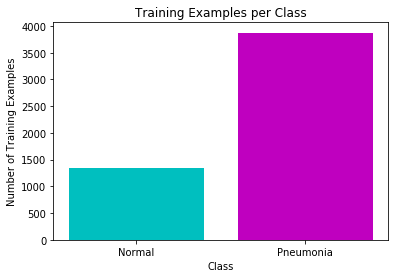

In [0]:
import matplotlib.pyplot as plt

print(normal_train_len, 'Normal training examples')
print(pneumonia_train_len, 'Pneumonia training examples')

plt.bar(np.arange(2), [normal_train_len, pneumonia_train_len], color=['c', 'm'])
plt.xlabel('Class')
plt.ylabel('Number of Training Examples')
plt.xticks(np.arange(2), ['Normal', 'Pneumonia'])
plt.title('Training Examples per Class')
plt.show()

8 Normal validation examples
8 Pneumonia validation examples


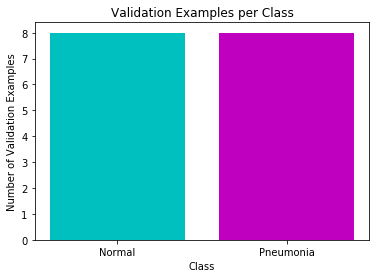

In [0]:
print(normal_val_len, 'Normal validation examples')
print(pneumonia_val_len, 'Pneumonia validation examples')

plt.bar(np.arange(2), [normal_val_len, pneumonia_val_len], color=['c', 'm'])
plt.xlabel('Class')
plt.ylabel('Number of Validation Examples')
plt.xticks(np.arange(2), ['Normal', 'Pneumonia'])
plt.title('Validation Examples per Class')
plt.show()

234 Normal test examples
390 Pneumonia test examples


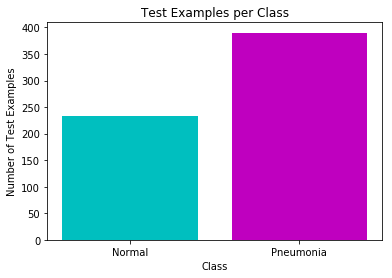

In [0]:
print(normal_test_len, 'Normal test examples')
print(pneumonia_test_len, 'Pneumonia test examples')
plt.bar(np.arange(2), [normal_test_len, pneumonia_test_len], color=['c', 'm'])
plt.xlabel('Class')
plt.ylabel('Number of Test Examples')
plt.xticks(np.arange(2), ['Normal', 'Pneumonia'])
plt.title('Test Examples per Class')
plt.show()

**Note:**
*   These plots demonstrate the clear class imbalance present in the data.  Quite a few more examples of pneumonia than non-pneumonia patients in both the training and test sets.


**Visualize chest x-ray images**

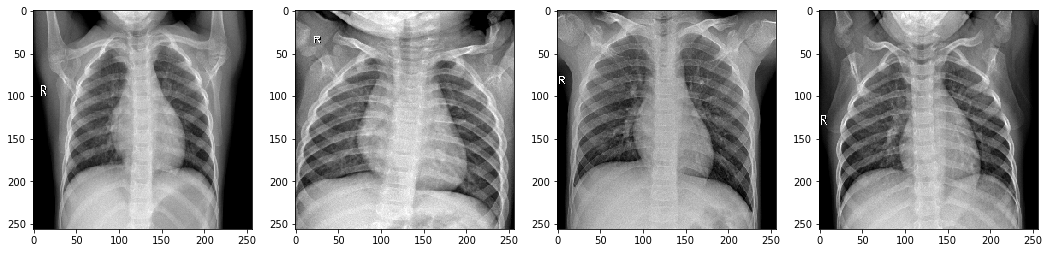

In [0]:
# Normal Images:

fig = plt.figure(figsize=(18, 16))

img_count = 0
for i, label in enumerate(train_labels):
    if label == 0:
        ax = fig.add_subplot(1, 4, img_count + 1)
        ax.imshow(train_data[i].squeeze(), cmap='gray')
        img_count += 1
    if img_count > 3:
        break

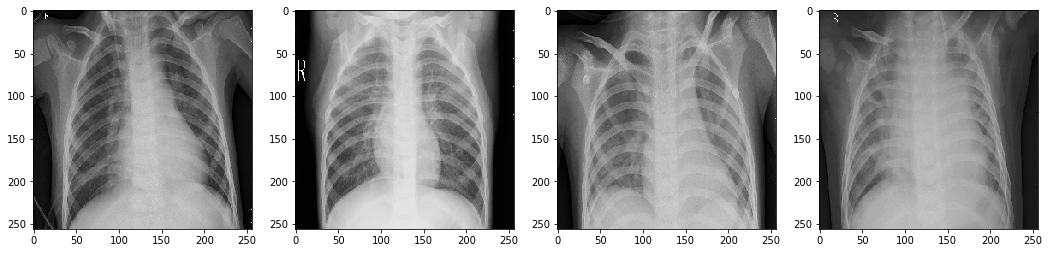

In [0]:
# Pneumonia Images:

fig = plt.figure(figsize=(18, 16))

img_count = 0
for i, label in enumerate(train_labels):
    if label == 1:
        ax = fig.add_subplot(1, 4, img_count + 1)
        ax.imshow(train_data[i].squeeze(), cmap='gray')
        img_count += 1
    if img_count > 3:
        break

**Note:**
*   The structure of the images between the two classes are very similar.  All images represent a torso x-ray, with similar rotations, colors, and body structure.
*   The difference with the pneumonia images seems to be a clouding in the lungs, which you can see in-between the bones of the ribcage.  A good network will likely need to look for this specifically.



## Section 3: Modeling - Neural Networks

In summary, this section fits a number of neural networks, comparing processing time and performance across experimental treatments.

#### Basic CNN Model

The first model will include a basic architecture that was refined over many experiments with the data.  It includes the following layers:


1.   Convolutional
2.   Pooling
3.   Convolutional
4.   Pooling
5.   Flatten
6.   Dropout
7.   Dense
8.   Dense

**Note:** Because the dataset is unbalanced, the model will be evaulated via accuracy, precision, and recall.  Advanced preprocessing and training methods will be employed in later models.


In [0]:
from keras import backend as K
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers

In [0]:
K.clear_session()

W0625 22:43:34.649631 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0625 22:43:34.654258 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0625 22:43:34.684145 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
# Create a model and add layers
# model structure
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), 
                        activation='relu', 
                        input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

W0625 22:43:34.700229 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 22:43:34.704527 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 22:43:34.747348 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0625 22:43:34.778532 140463512811392 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please us

In [0]:
# custom metrics
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [0]:
# Compile the model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = callbacks.ModelCheckpoint(filepath='basic_model.h5',
                                       monitor='val_loss',
                                       save_best_only=True)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc', precision_m, recall_m])

W0625 22:43:34.853534 140463512811392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 22:43:34.862816 140463512811392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# show a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 4)       40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 4)       148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15376)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 30754     
__________

In [0]:
# set model hyperparameters
batch_size = 16
epochs = 50

In [0]:
# Train the model
%%time
history = model.fit(train_data, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_data, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 8s 2ms/step - loss: 0.4738 - acc: 0.7634 - precision_m: 0.7602 - recall_m: 0.9975 - val_loss: 0.6944 - val_acc: 0.5625 - val_precision_m: 0.5333 - val_recall_m: 1.0000
Epoch 2/50
5216/5216 [==============================] - 3s 556us/step - loss: 0.3423 - acc: 0.8512 - precision_m: 0.8409 - recall_m: 0.9898 - val_loss: 0.7608 - val_acc: 0.6250 - val_precision_m: 0.5714 - val_recall_m: 1.0000
Epoch 3/50
5216/5216 [==============================] - 3s 550us/step - loss: 0.3037 - acc: 0.8855 - precision_m: 0.8809 - recall_m: 0.9813 - val_loss: 0.6235 - val_acc: 0.6875 - val_precision_m: 0.6154 - val_recall_m: 1.0000
Epoch 4/50
5216/5216 [==============================] - 3s 545us/step - loss: 0.2825 - acc: 0.9062 - precision_m: 0.9006 - recall_m: 0.9829 - val_loss: 0.9413 - val_acc: 0.6250 - val_precision_m: 0.5714 - val_recall_m: 1.0000
Epoch 5/50
5216/5216 [==============================

Evaluate model performance

In [0]:
# Plotting the training and validation accuracy, loss, and precision

def show_training_plots(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision_m = history.history['precision_m']
    val_precision_m = history.history['val_precision_m']
    recall_m = history.history['recall_m']
    val_recall_m = history.history['val_recall_m']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--', color='c', lw=2, label='Training acc')
    plt.plot(epochs, val_acc, '--', color='m', lw=2, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, '--', color='c', lw=2, label='Training loss')
    plt.plot(epochs, val_loss, '--', color='m', lw=2, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.figure()
    
    plt.plot(epochs, precision_m, '--', color='c', lw=2, label='Training precision')
    plt.plot(epochs, val_precision_m, '--', color='m', lw=2, label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()

    plt.figure()
    
    plt.plot(epochs, recall_m, '--', color='c', lw=2, label='Training recall')
    plt.plot(epochs, val_recall_m, '--', color='m', lw=2, label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()

    plt.figure()
    
    plt.show()

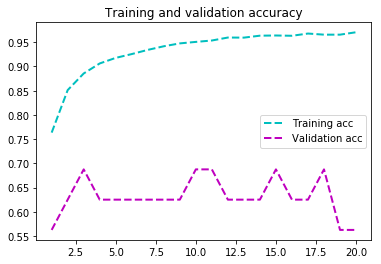

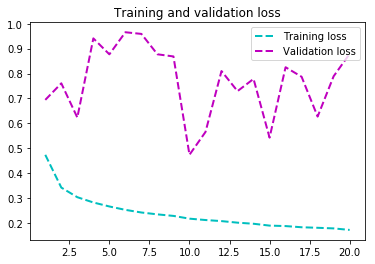

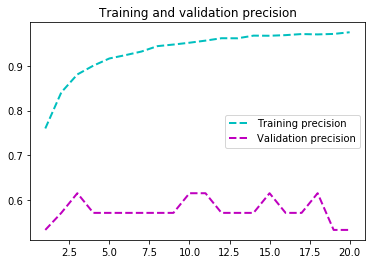

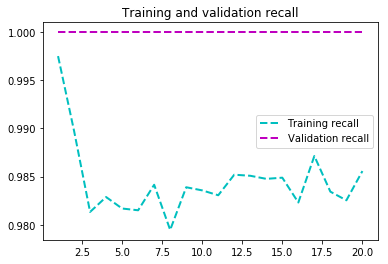

<Figure size 432x288 with 0 Axes>

In [0]:
# show plots
show_training_plots(history)

In [0]:
# Visualizing of confusion matrix:

import seaborn as sns

def create_cm_plot(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='viridis')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Normal (0)', 'Pneumonia (1)'])
    ax.yaxis.set_ticklabels(['Normal (0)', 'Pneumonia (1)'])
    plt.show()

5216/5216 [==============================] - 2s 310us/step
[[1222  119]
 [  25 3850]]


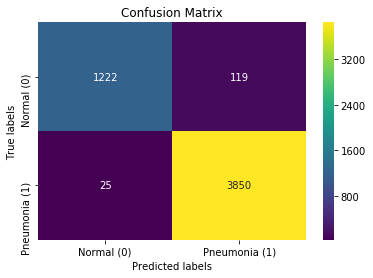

In [0]:
from sklearn.metrics import confusion_matrix

predicted_train_labels = model.predict(train_data,
                                       batch_size=batch_size,
                                       verbose=1)

cm = confusion_matrix(train_labels, predicted_train_labels.round())
print(cm)
create_cm_plot(cm)

16/16 [==============================] - 0s 708us/step
[[1 7]
 [0 8]]


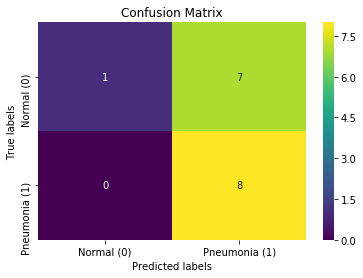

In [0]:
predicted_val_labels = model.predict(val_data,
                                     batch_size=batch_size,
                                     verbose=1)

cm = confusion_matrix(val_labels, predicted_val_labels.round())
print(cm)
create_cm_plot(cm)

**Note:**
*   This model overfits pretty heavily, and the accuracy on the validation set is pretty poor.
*   It looks like the model is overpredicting pneumonia, likely because of the heavy class imbalance

#### Data Augmentation

For data augmentation we will rotate the images, apply noise, and randomly flip inputs horizontally. Data augmentation is a popular way to artificially increase the size of your training set by manipulating the training images.  The assumption with augmentation is that the manipulations will result in an image that could realistically be seen in the training data, but is different enough from the original image to force the network to change its activations slightly.


We'll use a fairly basic form of data augmentation here.  Each image will randomly be assigned a slight transformation and a that copy will be added to the dataset in addition to the original.  This effectively doubles our training set. Because all of the images in this dataset are fairly similar, we'll have to carefully apply augmentation to avoid creating unrealistic images.

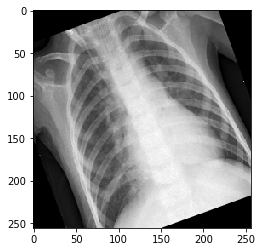

In [0]:
# Good transformations:

import skimage as sk

# rotation
test_rotate = sk.transform.rotate(train_data[0], 20)
plt.imshow(test_rotate.squeeze(), cmap='gray')

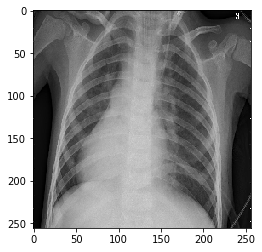

In [0]:
# horizontal flip
plt.imshow(train_data[0][:,::-1].squeeze(), cmap='gray')

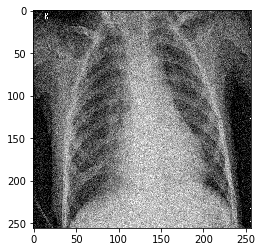

In [0]:
# Bad transformation:

# noise addition
test_noise = sk.util.random_noise(train_data[0])
plt.imshow(test_noise.squeeze(), cmap='gray')

**Note:**
*   The rotation example looks good, although we'd want to avoid rotating more than 20%
*   The horizontal flipping looks good because the torso is symmetrical and pneumonia could show up in either lung
*   The random noise addition seems to mask exactly what we are looking for in the image, a clouding of the lungs.  Do not recommend the use of this augmentation technique.

In [0]:
# Create transformation functions and dictionary:

import random

def random_rotate(img):
    # randomly selects rotation between -20% and 20%
    random_perc = random.uniform(-20, 20)
    return sk.transform.rotate(img, random_perc)

def horizontal_flip(img):
    # flip on y axis
    return img[:,::-1]

# dictionary of available transformation functions
available_transforms = {
    'rotate': random_rotate,
    'flip': horizontal_flip
}

In [0]:
# Generating new versions of each train_data image based on one of the transformations above:

random.seed(55)

train_data_aug = train_data.copy()
train_labels_aug = train_labels.copy()

# augment training data
for i, img in enumerate(train_data_aug):
    key = random.choice(list(available_transforms))
    trans_img = available_transforms[key](img)
    train_data_aug[i] = trans_img

In [0]:
# check shape
train_data_aug.shape

(5216, 256, 256, 1)

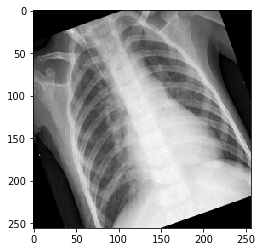

In [0]:
# check results

plt.imshow(train_data_aug[0].squeeze(), cmap='gray')

In [0]:
# Append original train_data to train_data_aug, then shuffle:

# append
train_data_aug = np.append(train_data_aug, train_data, axis=0)
train_labels_aug = np.append(train_labels_aug, train_labels, axis=0)

# shuffle data
train_data_aug, train_labels_aug = shuffle(train_data_aug, 
                                           train_labels_aug,
                                           random_state=39)

In [0]:
# check shape
train_data_aug.shape

(10432, 256, 256, 1)

In [0]:
train_labels_aug.shape

(10432, 1)

#### CNN with Data Augmentation

Next, we'll utilize the same model architecture as before and see how the data augmentation affects training.

In [0]:
# ### Train Model
K.clear_session()

In [0]:
# model structure
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), 
                        activation='relu', 
                        input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# compile model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = callbacks.ModelCheckpoint(filepath='augmented_model.h5',
                                       monitor='val_loss',
                                       save_best_only=True)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc', precision_m, recall_m])

In [0]:
# set hyperparameters
batch_size = 16
epochs = 50

In [0]:
# train the model with the augmented data
%%time
history = model.fit(train_data_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(test_data, test_labels))

Train on 10432 samples, validate on 624 samples
Epoch 1/50
10432/10432 [==============================] - 12s 1ms/step - loss: 0.6859 - acc: 0.7410 - precision_m: 0.7418 - recall_m: 0.9961 - val_loss: 0.6861 - val_acc: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6410
Epoch 2/50
10432/10432 [==============================] - 12s 1ms/step - loss: 0.6727 - acc: 0.7429 - precision_m: 0.7429 - recall_m: 1.0000 - val_loss: 0.6802 - val_acc: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6410
Epoch 3/50
10432/10432 [==============================] - 12s 1ms/step - loss: 0.6604 - acc: 0.7429 - precision_m: 0.7429 - recall_m: 1.0000 - val_loss: 0.6751 - val_acc: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6410
Epoch 4/50
10432/10432 [==============================] - 12s 1ms/step - loss: 0.6491 - acc: 0.7429 - precision_m: 0.7429 - recall_m: 1.0000 - val_loss: 0.6710 - val_acc: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6410
Epoch 5/50
10432/10432 [====================

#### Evaluate Model

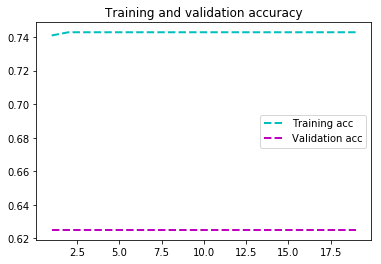

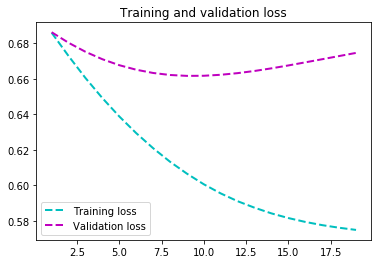

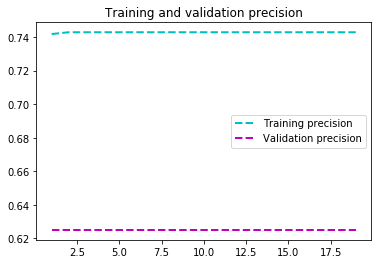

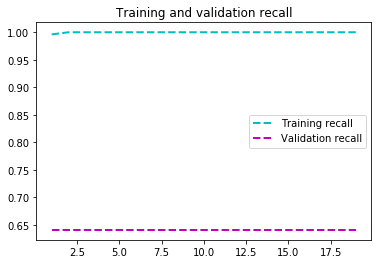

<Figure size 432x288 with 0 Axes>

In [0]:
# Training plots:
show_training_plots(history)

10432/10432 [==============================] - 8s 758us/step
[[   0 2682]
 [   0 7750]]


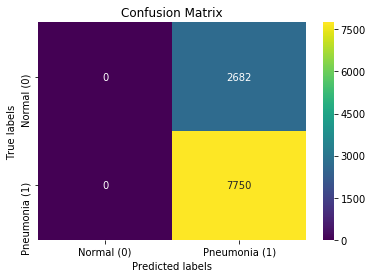

In [0]:
# visualizing confusion matrix
predicted_train_labels = model.predict(train_data_aug,
                                       batch_size=batch_size,
                                       verbose=1)

cm = confusion_matrix(train_labels_aug, predicted_train_labels.round())
print(cm)
create_cm_plot(cm)

16/16 [==============================] - 0s 770us/step
[[0 8]
 [0 8]]


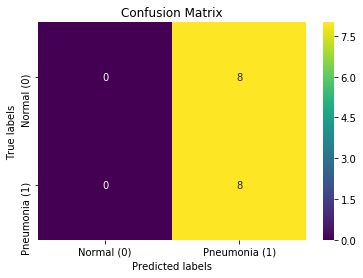

In [0]:
# create validation confusion matrix
predicted_val_labels = model.predict(val_data,
                                     batch_size=batch_size,
                                     verbose=1)

cm = confusion_matrix(val_labels, predicted_val_labels.round())
print(cm)
create_cm_plot(cm)

**Note:**
*   The augmentation has slowed the overfitting substantially, but it is still occurring
*   The model is still failing to predict normal patients as often as it should

### Model With Class Weights


In heavily-imbalanced datasets, the loss function can be altered to penalize predicting the overrepresented class more than predicting the underrepresented class.  We'll use this through an argument to the model.fit() function in Keras.

In [0]:
# Train Model
K.clear_session()

In [0]:
# model structure
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), 
                        activation='relu', 
                        input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# compile model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = callbacks.ModelCheckpoint(filepath='class_weight_model.h5',
                                       monitor='val_loss',
                                       save_best_only=True)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc', precision_m, recall_m])

In [0]:
# set model hyperparameters
batch_size = 16
epochs = 50

In [0]:
# train the model with augmented data and class weights
%%time
history = model.fit(train_data_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(test_data, test_labels),
                    class_weight={0:74, 1:26})

Train on 10432 samples, validate on 624 samples
Epoch 1/50
10432/10432 [==============================] - 13s 1ms/step - loss: 24.5626 - acc: 0.7932 - precision_m: 0.8467 - recall_m: 0.9025 - val_loss: 0.5058 - val_acc: 0.8494 - val_precision_m: 0.6368 - val_recall_m: 0.5486
Epoch 2/50
10432/10432 [==============================] - 13s 1ms/step - loss: 13.7446 - acc: 0.8685 - precision_m: 0.9582 - recall_m: 0.8587 - val_loss: 0.3700 - val_acc: 0.8381 - val_precision_m: 0.6359 - val_recall_m: 0.5267
Epoch 3/50
10432/10432 [==============================] - 13s 1ms/step - loss: 9.7154 - acc: 0.8996 - precision_m: 0.9729 - recall_m: 0.8897 - val_loss: 0.3406 - val_acc: 0.8558 - val_precision_m: 0.6368 - val_recall_m: 0.5598
Epoch 4/50
10432/10432 [==============================] - 12s 1ms/step - loss: 8.1009 - acc: 0.9136 - precision_m: 0.9761 - recall_m: 0.9074 - val_loss: 0.3518 - val_acc: 0.8638 - val_precision_m: 0.6368 - val_recall_m: 0.5855
Epoch 5/50
10432/10432 [==================

#### Evaluate Model


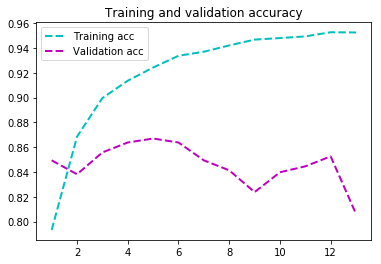

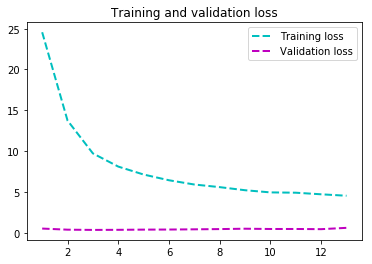

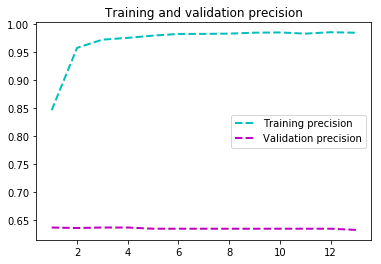

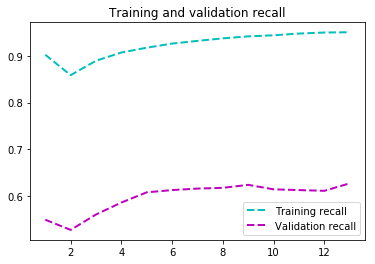

<Figure size 432x288 with 0 Axes>

In [0]:
show_training_plots(history)

10432/10432 [==============================] - 7s 712us/step
[[2577  105]
 [ 284 7466]]


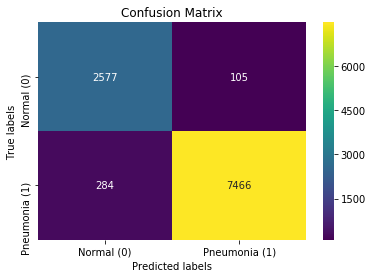

In [0]:
# visualizing confusion matrix
predicted_train_labels = model.predict(train_data_aug,
                                       batch_size=batch_size,
                                       verbose=1)
cm = confusion_matrix(train_labels_aug, predicted_train_labels.round())
print(cm)
create_cm_plot(cm)

16/16 [==============================] - 0s 635us/step
[[5 3]
 [0 8]]


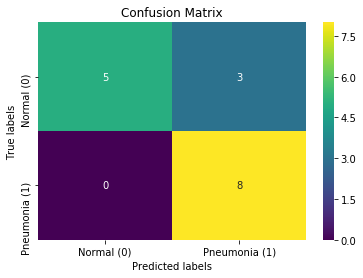

In [0]:
# create validation confusion matrix
predicted_val_labels = model.predict(val_data,
                                     batch_size=batch_size,
                                     verbose=1)
cm = confusion_matrix(val_labels, predicted_val_labels.round())
print(cm)
create_cm_plot(cm)

**Note:**
*   With the addition of augmentation and class weights, the model is fitting much better now



#### Visualizing what convnets learn

In this section we'll attempt to evaluate what the convnet has learned.  We'll do this through visualizing intermediate activations given a test image.  Because there are only two convolutional layers in our network, we should be able to look at each channel easily.


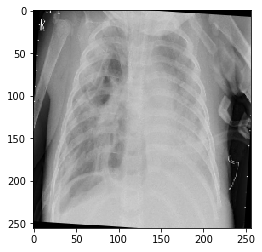

In [0]:
# sample image
sample_img = train_data_aug[0]
plt.imshow(sample_img.squeeze(), cmap='gray')

In [0]:
# Sample image prediction from our model:
sample_img = np.expand_dims(sample_img, axis=0)
sample_prediction = model.predict(sample_img).round()
print('Prediction = ', sample_prediction[0][0])

Prediction =  1.0


In [0]:
# Actual value:
print('True value = ', train_labels_aug[0][0])

True value =  1


In [0]:
# Creating activations:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(sample_img)

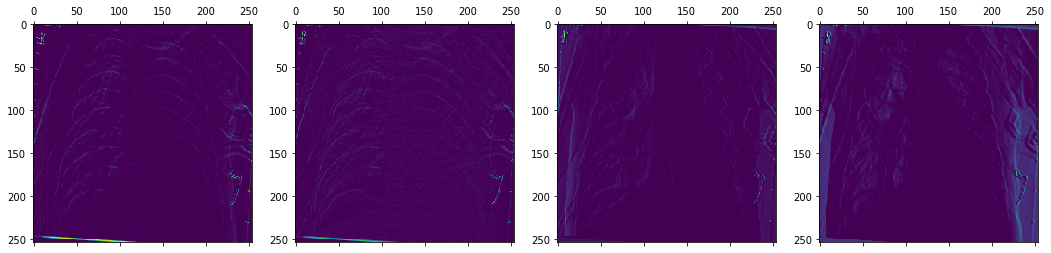

In [0]:
# Looking at the first layer activations:
fig = plt.figure(figsize=(18, 16))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.matshow(activations[0][0, :, :, i])

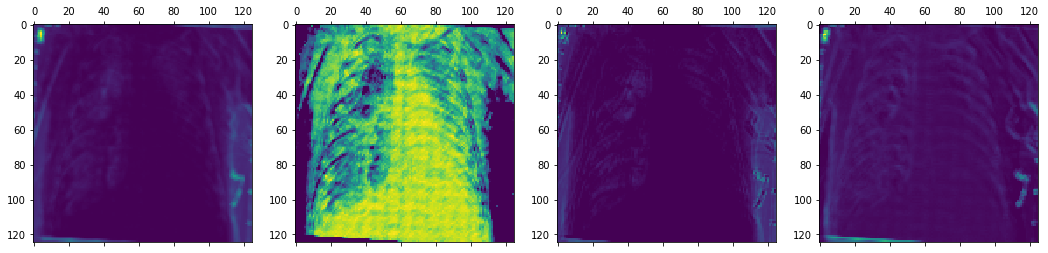

In [0]:
# Looking at the third layer activations:

fig = plt.figure(figsize=(18, 16))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.matshow(activations[2][0, :, :, i])

**Note:**
*   The first layer looks like it is mostly grabbing edges, which effectively recreates the image because it is grayscale
*   The second layer is much more interesting.  It appears to be looking in-between the ribcage at the lung.  This is exactly where it would need to look for signs of pneumonia.



#### Evaluating Final Model on Test Data

Now that we have a model that is performing well and is interpretable, we will use it to predict the reserved test data.  These predictions will be compared to their true value to determine the model's effectiveness.

![Confusion Matrix](https://cdn-images-1.medium.com/max/800/1*Yslau43QN1pEU4jkGiq-pw.png)

Let us give a short description of these metrics. The accuracy of the model is basically the total number of correct predictions divided by total number of predictions. The precision of a class define how trustable is the result when the model answer that a point belongs to that class. The recall of a class expresses how well the model is able to detect that class.

*   high recall + high precision : the class is perfectly handled by the model
*   low recall + high precision : the model can’t detect the class well but is highly trustable when it does
*   high recall + low precision : the class is well detected but the model also include points of other classes in it
*   low recall + low precision : the class is poorly handled by the model



624/624 [==============================] - 1s 803us/step
[[122 112]
 [  9 381]]


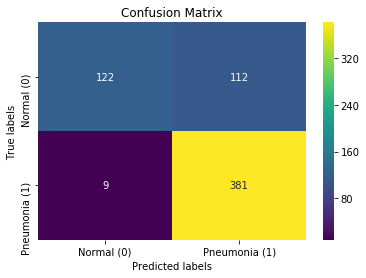

In [0]:
# visualizing confusion matrix for test data
predicted_test_labels = model.predict(test_data,
                                      batch_size=batch_size,
                                      verbose=1)

cm = confusion_matrix(test_labels, predicted_test_labels.round())
print(cm)
create_cm_plot(cm)

In [0]:
print('Model Accuracy = ', (381 + 122) / 624)
print('Model Precision = ', 381 / (381 + 112))
print('Model Recall = ', 381 / (381 + 9))

Model Accuracy =  0.8060897435897436
Model Precision =  0.7728194726166329
Model Recall =  0.9769230769230769


## Section 4:  Conclusion

**Management problem: ** Suppose you are asked to develop a neural network model for a computer vision task such as facial recognition of the user of a mobile device such as a cell phone. Rather than requiring a log-in user name and password or a four-digit key-code, the device requires facial recognition of the user. How would you go about training such a model? Would such a model require deep learning (more than one hidden layer of nodes)/ Would there be any advantage to employing convolutional layers? How would you judge the model's accuracy with real data examples, such as recognition of the face for a cell phone user?

>**Summary Table of Models:**


**In Conclusion:**

After fitting a number of neural networks, processing time and performance was compared across experimental treatments.

The results showed:

*    While the accuracy and precision are decent, the real win here is the high recall value.
*    Because this model may be used to assist in diagnostic imaging, a high rate of false negatives could lead to patients failing to get treatment when needed.
*    It is much better to have false positives in this case, as the presence of pneumonia could be ruled out through other means.
*    The deep CNN model with data augmentation and class weights resulted in the most accurate predictions for image data.

In summary, when developing a model for a computer vision task such as a medical diagnoses
